## Libraries

In [1]:
import datetime
import warnings
import logging
import random
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, SimpleRNN, GRU

from keras.wrappers.scikit_learn import KerasRegressor

In [2]:
from warnings import filterwarnings
from sklearn.exceptions import ConvergenceWarning
import warnings

ConvergenceWarning('ignore')
filterwarnings('ignore')
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore', category = ConvergenceWarning)

# Loading Data

In [3]:
df = pd.read_csv('mock_kaggle.csv')

df.head()

,data,venda,estoque,preco
0,2014-01-01,0,4972,1.29
1,2014-01-02,70,4902,1.29
2,2014-01-03,59,4843,1.29
3,2014-01-04,93,4750,1.29
4,2014-01-05,96,4654,1.29


Renaming columns and changing the data type for DATE

In [4]:
df = df[['data', 'venda']]
df.rename(columns = {'data': 'DATE', 'venda': 'Q'},
          inplace = True)

df['DATE'] = pd.to_datetime(df['DATE'], format = '%Y-%m-%d')

df.head()

,DATE,Q
0,2014-01-01,0
1,2014-01-02,70
2,2014-01-03,59
3,2014-01-04,93
4,2014-01-05,96


In [5]:
df.dtypes

DATE    datetime64[ns]
Q                int64
dtype: object

## Class for Demand Forecasting

The 'preprocess' function takes care of the following items:
- create independent variables by lagging a dependent variable;
- create independent variables by calculating the mean/max/min of the lagged values;
- create 'MONTH' independent variables
- split dataset into train_val & test datasets with walk forward validation, and;
- scale datasets.

The 'set_seed' function set seeds for DL models (used in the 'predict' function).\
The 'disable_warning' function hashes warning messages by tensorflow (used in the 'predict' function).\
The 'DL_model' function complies DL models (used in the 'predict' function).\
The 'predict' function outputs the predictions according to the specified list of hyperparameters.\
The 'plot' function visualises predictions against test set.

In [6]:
class main:
    
    def __init__(self, df):
        self.df = df
        self.dates = df['DATE']
       
    # Preprocessing inlcludes feature engineering, scaling, and train/validation/test split
    def preprocess(self, lag_s = 1, lag_e = 30, n_pred = 30, test_size = None):
        
        self.n_pred    = n_pred
        self.test_size = test_size
        
        df = self.df
        
        # Lagged values
        for i in range(lag_s, lag_e):
            df[f'Q-{i}'] = df['Q'].shift(i)

        # Rolling mean, maximum & minimum
        for i in range(lag_s, lag_e):
            df[f'roll_mean-Q{lag_s}_{i}'] = df[f'Q-{lag_s}'].rolling(i - lag_s + 1).mean()
            df[f'roll_max-Q{lag_s}_{i}']  = df[f'Q-{lag_s}'].rolling(i - lag_s + 1).max()
            df[f'roll_min-Q{lag_s}_{i}']  = df[f'Q-{lag_s}'].rolling(i - lag_s + 1).min()

        df = df.drop(columns = [f'roll_mean-Q{lag_s}_{lag_s}',
                                f'roll_max-Q{lag_s}_{lag_s}',
                                f'roll_min-Q{lag_s}_{lag_s}'])

        # Dropping those columns with NA values due to creatiing lagged values
        df = df.dropna(axis = 0)
        df = df.reset_index(drop = True)

        # Creating month columns w/ one hot encoding
        df['MONTH'] = df['DATE'].dt.month
        df = pd.get_dummies(data = df, columns = ['MONTH'], drop_first = True, prefix = 'M')
        
        df = df.drop(columns = 'DATE')
        
        self.df = df
    
        # Cross validation without scaling
        self.x = self.df.drop(columns = ['Q'])
        self.y = self.df['Q']

        self.x_train_val = self.x.iloc[:-n_pred, :]
        self.y_train_val = self.y[:-n_pred]
        self.x_test      = self.x.iloc[-n_pred:, :]
        self.y_test      = self.y[-n_pred:]

        # Used for creating layers in DL models
        self.input_shapes = self.x_train_val.shape

        # Scalers for x & y
        self.x_scaler = MinMaxScaler(feature_range = (0, 1))
        self.y_scaler = MinMaxScaler(feature_range = (0, 1))

        # Scaling x & y
        self.x_scaled = self.x_scaler.fit_transform(self.x.values)
        self.y_scaled = self.y_scaler.fit_transform(self.y.values.reshape(-1, 1))

        # Splitting dataframes into xs and ys
        self.x_train_val_scaled = self.x_scaled[:-n_pred, :]
        self.y_train_val_scaled = self.y_scaled[:-n_pred, :]

        self.x_test_scaled = self.x_scaled[-n_pred:, :]

        # Reshaping y dataset into 1D array, otherwise SVR returns warning
        self.y_train_val_scaled = self.y_train_val_scaled.reshape(-1)
        
        # Creating predictions with a baseline model, which is naive method
        pred = [self.y_train_val.values[-1]] * n_pred
        RMSE = str(round(np.sqrt(mean_squared_error(self.y_test, pred))))
        MAE  = str(round(mean_absolute_error(self.y_test, pred)))
        MAPE = str(round(mean_absolute_percentage_error(self.y_test, pred) * 100, 1)) + '%'
        now  = datetime.datetime.now().strftime('%Y-%m-%d %H:%M')
        
        self.results_all = [[now, 'Naive method', RMSE, MAE, MAPE, pred, None]]
        self.results_all = pd.DataFrame(self.results_all, columns = ['Datetime', 'Model', 'RMSE', 'MAE', 'MAPE', 'Pred', 'Params'])
        self.results = self.results_all.drop(columns = ['Pred', 'Params'])
        

    # Setting seed for DL models
    def set_seed(self, seed = 0):
        tf.random.set_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        os.environ['PYTHONHASHSEED'] = str(seed)
    
    
    # Disabling annoying tensorflow warnings
    def disable_warning(self):
        os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
        warnings.simplefilter(action = 'ignore', category = FutureWarning)
        warnings.simplefilter(action = 'ignore', category = Warning)

        tf.get_logger().setLevel('INFO')
        tf.autograph.set_verbosity(0)

        tf.get_logger().setLevel(logging.ERROR)

    
    # Compiling DL model, to be used later
    def DL_model(self, model_nm, n_layers = 2, n_nodes = 5, dropout_rate = 0.1, optimizer = 'adam'):
        model = Sequential()

        for i in range(1, n_layers):
            if   model_nm == 'RNN':
                self.set_seed()
                self.disable_warning()
                model.add(SimpleRNN(n_nodes, input_shape = (1, self.input_shapes[1]), return_sequences = True))
            elif model_nm == 'LSTM':
                self.set_seed()
                self.disable_warning()
                model.add(LSTM(n_nodes, input_shape = (1, self.input_shapes[1]), return_sequences = True))
            elif model_nm == 'GRU':
                self.set_seed()
                self.disable_warning()
                model.add(GRU(n_nodes, input_shape = (1, self.input_shapes[1]), return_sequences = True))

            model.add(Dropout(dropout_rate))

        model.add(Dense(1))
        model.compile(loss = 'mae', optimizer = optimizer)

        return model

    # Predicting the results with the specified sets of hyperparameters
    def predict(self, model_params, random_state = 0):
        # Storing evaluation metrics and parameters for each model
        results_all = []

        # For each model
        for model_nm in model_params.keys():

            # Printing out the model name first with the started time
            print(model_nm, 'starts at', datetime.datetime.now().strftime('%Y-%m-%d %H:%M'))

            # Getting the list of hyperparameters for the specified model
            params = model_params[model_nm]

            # Specifying the model
            if   model_nm == 'GBR':
                model = GradientBoostingRegressor(random_state = random_state)
            elif model_nm == 'LGBM':
                model = LGBMRegressor(random_state = random_state)
            elif model_nm == 'XGB':
                model = XGBRegressor(random_state = random_state)
            elif model_nm == 'SVR':
                model = SVR()
            elif model_nm == 'Ridge':
                model = Ridge(random_state = random_state)
            elif model_nm == 'Lasso':
                model = Lasso(random_state = random_state)
            elif model_nm == 'EN':
                model = ElasticNet(random_state = random_state)
            elif model_nm in ['RNN', 'LSTM', 'GRU']:
                self.disable_warning()
                params.update({'model_nm': [model_nm]})
                model = KerasRegressor(build_fn = self.DL_model, verbose = False)

            # dist for saving MAEs and best parameters for each n_splits
            scores = {}

            # Hyper parameter tuning for n_splits & model's hyperparameters
            for i in range(5, 6):
                tscv = TimeSeriesSplit(n_splits = i, test_size = self.test_size)
                gscv = GridSearchCV(estimator  = model,
                                    cv         = tscv,
                                    param_grid = params,
                                    verbose    = 0,
                                    n_jobs     = 2 if model_nm in ['RNN', 'LSTM', 'GRU'] else -1,
                                    scoring    = 'neg_mean_absolute_error')

                if   model_nm in ['GBR', 'LGBM', 'XGB']:
                    gscv.fit(self.x_train_val, self.y_train_val)
                elif model_nm in ['RNN', 'LSTM', 'GRU']:
                    gscv.fit(self.x_train_val_scaled.reshape(self.input_shapes[0], 1, self.input_shapes[1]),
                             self.y_train_val_scaled.reshape(-1, 1))
                else:
                    gscv.fit(self.x_train_val_scaled, self.y_train_val_scaled)

                # Saving the best MAE and parameters for each n_split
                scores[i] = {'MAE'   : round(-gscv.best_score_),
                             'params': gscv.best_params_}

            # Obtaining the best parameters over all n_splits
            MAEs = [scores[key]['MAE'] for key in scores.keys()]
            MAE_min = min(MAEs)

            for key in scores.keys():
                if scores[key]['MAE'] == MAE_min:
                    best_params = scores[key]['params']
                    break

            # Building the specified model with the best parameters
            if   model_nm == 'GBR':
                model = GradientBoostingRegressor(random_state = random_state, **best_params)
            elif model_nm == 'LGBM':
                model = LGBMRegressor(random_state = random_state, **best_params)
            elif model_nm == 'XGB':
                model = XGBRegressor(random_state = random_state, **best_params)
            elif model_nm == 'SVR':
                model = SVR(**best_params)
            elif model_nm == 'Ridge':
                model = Ridge(random_state = random_state, **best_params)
            elif model_nm == 'Lasso':
                model = Lasso(random_state = random_state, **best_params)
            elif model_nm == 'EN':
                model = ElasticNet(random_state = random_state, **best_params)
            elif model_nm in ['RNN', 'LSTM', 'GRU']:
                epochs = best_params.pop('nb_epoch')           # Removing to be used in the below "fit"
                batch_size = best_params.pop('batch_size')     # Removing to be used in the below "fit"
                model = self.DL_model(**best_params)           # Building a model w/o epochs or batch size
                best_params.pop('model_nm')                    # Removing as it is not a parameter per se
                best_params.update({'nb_epoch'  : epochs,      # Putting it back to be returned as the best parameter
                                    'batch_size': batch_size}) # Putting it back to be returned as the best parameter

            # Prediction
            if model_nm in ['GBR', 'LGBM', 'XGB']:
                model.fit(self.x_train_val, self.y_train_val)
                pred = model.predict(self.x_test)
            elif model_nm in ['RNN', 'LSTM', 'GRU']:
                model.fit(self.x_train_val_scaled.reshape(self.input_shapes[0], 1, self.input_shapes[1]),
                          self.y_train_val_scaled.reshape(-1, 1),
                          epochs = epochs, batch_size = batch_size, verbose = 0)
                pred_scaled = model.predict(self.x_test_scaled.reshape(self.n_pred, 1, self.input_shapes[1]))
                pred        = self.y_scaler.inverse_transform(pred_scaled.reshape(-1, 1))
                pred        = pred.reshape(-1)
            else:
                model.fit(self.x_train_val_scaled, self.y_train_val_scaled)
                pred_scaled = model.predict(self.x_test_scaled)
                pred        = self.y_scaler.inverse_transform(pred_scaled.reshape(-1, 1))
                pred        = pred.reshape(-1)

            # Calculating the evaluation metrics on the test set
            RMSE = str(round(np.sqrt(mean_squared_error(self.y_test, pred))))
            MAE  = str(round(mean_absolute_error(self.y_test, pred)))
            MAPE = str(round(mean_absolute_percentage_error(self.y_test, pred) * 100, 1)) + '%'
            
            now = datetime.datetime.now().strftime('%Y-%m-%d %H:%M')
            results_all.append([now, model_nm, RMSE, MAE, MAPE, pred, best_params])
            
        results_all = pd.DataFrame(results_all, columns = ['Datetime', 'Model', 'RMSE', 'MAE', 'MAPE', 'Pred', 'Params'])
        
        self.results_all = pd.concat([self.results_all, results_all])
        self.results_all = self.results_all.reset_index(drop = True)
        self.results = self.results_all.drop(columns = ['Pred', 'Params'])
        
        print('All Finished at', datetime.datetime.now().strftime('%Y-%m-%d %H:%M'))
       
    # Deleting all the prediction results when called
    def delete_results(self):
        self.results_all = pd.DataFrame({}, columns = ['Datetime', 'Model', 'RMSE', 'MAE', 'MAPE', 'Pred', 'Params'])
        self.results     = None
    
    # Plotting the prediction results
    def plot(self, model_nm = None):
        
        # If a model is specified, its retults are going to be shown
        if model_nm != None:
            Model = model_nm
            
            idx = self.results_all[self.results_all['Model'] == model_nm].index[0]

            Pred  = self.results_all.loc[idx, 'Pred']
            RMSE  = self.results_all.loc[idx, 'RMSE']
            MAE   = self.results_all.loc[idx, 'MAE']
            MAPE  = self.results_all.loc[idx, 'MAPE']
            
            plt.figure(figsize = (12, 2))
            plt.plot(self.dates[-self.n_pred:], self.y_test, label = 'Actual')
            plt.plot(self.dates[-self.n_pred:], Pred,        label = 'Predicted')
            plt.legend()
            plt.grid()
            plt.xlabel('Date')
            plt.ylabel('Quantity')
            plt.title(Model + ';  RMSE:' + RMSE + ', MAE:' + MAE + ', MAPE:' + MAPE )
            plt.show()
            
        # If no model is specified, all the results are going to be plotted   
        else:
            for i in range(len(self.results)):

                Model = self.results_all.loc[i, 'Model']
                Pred  = self.results_all.loc[i, 'Pred']
                RMSE  = self.results_all.loc[i, 'RMSE']
                MAE   = self.results_all.loc[i, 'MAE']
                MAPE  = self.results_all.loc[i, 'MAPE']

                plt.figure(figsize = (12, 2))
                plt.plot(self.dates[-self.n_pred:], self.y_test, label = 'Actual')
                plt.plot(self.dates[-self.n_pred:], Pred,        label = 'Predicted')
                plt.legend()
                plt.grid()
                plt.xlabel('Date')
                plt.ylabel('Quantity')
                plt.title(Model + ';  RMSE:' + RMSE + ', MAE:' + MAE + ', MAPE:' + MAPE )
                plt.show()

## List of hyperparameters for each model

Below are the combinations of hyperparameters.\
For explanatory purposes, not all combinations are sought, as it would take a long time.

In [7]:
GBR_params = {'learning_rate': [0.001, 0.01, 0.1],
              'subsample'    : [0.1, 0.5, 1.0],
              'n_estimators' : [30, 50, 75, 100, 125, 150],
              'max_depth'    : [2, 4, 6, 8, 10]}

LGBM_params = {'learning_rate'    : [0.001, 0.01, 0.1],
               'n_estimators'     : [50, 75, 100, 125, 150],
               'max_depth'        : [2, 4, 6, 8, 10],
               'colsample_bytree' : [0.1, 0.5, 1.0],
               'subsample'        : [0.1, 0.5, 1.0],
               'min_child_samples': [1, 3, 5, 7, 9]}

XGB_params = {'learning_rate'    : [0.001, 0.01, 0.1],
              'n_estimators'     : [50, 75, 100, 125, 150],
              'max_depth'        : [2, 4, 6, 8, 10],
              'colsample_bytree' : [0.1, 0.5, 1.0],
              'subsample'        : [0.1, 0.5, 1.0],
              'min_child_weight' : [1, 3, 5, 7, 9]}

SVR_params = [{'C': [1, 10, 100, 1000], 'kernel': ['rbf'],     'gamma': [0.001, 0.01, 0.1]},
              {'C': [1, 10, 100, 1000], 'kernel': ['sigmoid'], 'gamma': [0.001, 0.01, 0.1]}]

Ridge_params = {'alpha': np.logspace(-5, 1, 10)}

Lasso_params = {'alpha': np.logspace(-5, 1, 10)}

EN_params = {'alpha'   : np.logspace(-5, 1, 10),
             'l1_ratio': np.logspace(-5, 1, 10)}

RNN_params = {'n_layers'    : [3, 4, 5],
              'n_nodes'     : [15, 30],
              'dropout_rate': [0.1, 0.3, 0.5],
              'optimizer'   : ['adam', 'rmsprop'],
              'nb_epoch'    : [30, 50],
              'batch_size'  : [15, 30]}

LSTM_params = {'n_layers'    : [3, 4, 5],
               'n_nodes'     : [15, 30],
               'dropout_rate': [0.1, 0.3, 0.5],
               'optimizer'   : ['adam', 'rmsprop'],
               'nb_epoch'    : [30, 50],
               'batch_size'  : [15, 30]}

GRU_params = {'n_layers'    : [3, 4, 5],
              'n_nodes'     : [15, 30],
              'dropout_rate': [0.1, 0.3, 0.5],
              'optimizer'   : ['adam', 'rmsprop'],
              'nb_epoch'    : [30, 50],
              'batch_size'  : [15, 30]}

In [8]:
model_params = {'GBR'  : GBR_params,
                'LGBM' : LGBM_params,
                'XGB'  : XGB_params,
                'SVR'  : SVR_params,
                'Ridge': Ridge_params,
                'Lasso': Lasso_params,
                'EN'   : EN_params,
                'RNN'  : RNN_params,
                'LSTM' : LSTM_params,
                'GRU'  : GRU_params}

## Fitting to the models

In [9]:
test = main(df)
test.preprocess()

test.predict(model_params)

GBR starts at 2023-11-25 13:32
LGBM starts at 2023-11-25 13:35
XGB starts at 2023-11-25 13:42
SVR starts at 2023-11-25 13:58
Ridge starts at 2023-11-25 13:58
Lasso starts at 2023-11-25 13:58


/Users/oharyo/miniconda3/envs/forecast/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.010e-01, tolerance: 1.760e-04
  model = cd_fast.enet_coordinate_descent(
/Users/oharyo/miniconda3/envs/forecast/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.726e-03, tolerance: 1.760e-04
  model = cd_fast.enet_coordinate_descent(
/Users/oharyo/miniconda3/envs/forecast/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

EN starts at 2023-11-25 13:58


/Users/oharyo/miniconda3/envs/forecast/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.856e-01, tolerance: 1.760e-04
  model = cd_fast.enet_coordinate_descent(
/Users/oharyo/miniconda3/envs/forecast/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.730e-01, tolerance: 4.844e-04
  model = cd_fast.enet_coordinate_descent(
/Users/oharyo/miniconda3/envs/forecast/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the featu

RNN starts at 2023-11-25 13:58
1/1 [==============================] - 0s 244ms/step
LSTM starts at 2023-11-25 14:08
1/1 [==============================] - 0s 364ms/step
GRU starts at 2023-11-25 14:32
1/1 [==============================] - 0s 339ms/step
All Finished at 2023-11-25 14:56


## Results

In [10]:
test.results_all

,Datetime,Model,RMSE,MAE,MAPE,Pred,Params
0,2023-11-25 13:32,Naive method,113,100,105.3%,"[247, 247, 247, 247, 247, 247, 247, 247, 247, ...",None
1,2023-11-25 13:35,GBR,77,54,56.5%,"[214.42231278232984, 230.58933610186074, 193.2...","{'learning_rate': 0.1, 'max_depth': 2, 'n_esti..."
2,2023-11-25 13:42,LGBM,71,50,53.3%,"[246.39068796932995, 278.344770823821, 135.202...","{'colsample_bytree': 0.5, 'learning_rate': 0.1..."
3,2023-11-25 13:58,XGB,70,51,52.9%,"[261.62988, 276.10922, 197.57097, 215.90881, 2...","{'colsample_bytree': 1.0, 'learning_rate': 0.1..."
4,2023-11-25 13:58,SVR,67,50,46.9%,"[242.10229715515825, 244.053579887079, 128.710...","{'C': 100, 'gamma': 0.001, 'kernel': 'sigmoid'}"
5,2023-11-25 13:58,Ridge,71,51,46.0%,"[214.50177124079522, 227.86468881296585, 154.4...",{'alpha': 10.0}
6,2023-11-25 13:58,Lasso,72,52,46.4%,"[206.5046297729022, 233.95657352841778, 170.02...",{'alpha': 0.001}
7,2023-11-25 13:58,EN,71,52,48.4%,"[226.3034757210929, 240.96987417756498, 161.92...","{'alpha': 0.001, 'l1_ratio': 0.46415888336127725}"
8,2023-11-25 14:08,RNN,108,93,61.4%,"[128.11504, 143.39369, 79.74013, 81.90165, 104...","{'dropout_rate': 0.1, 'n_layers': 5, 'n_nodes'..."
9,2023-11-25 14:32,LSTM,82,67,48.4%,"[200.53755, 191.87717, 85.83535, 90.38737, 148...","{'dropout_rate': 0.1, 'n_layers': 3, 'n_nodes'..."


SVR turns out to be the best model in terms of RMSE and MAE.\
For deep learning models, it needs further exploration of hyperparameters, as its combinations of hyperpapameters considered were limited.

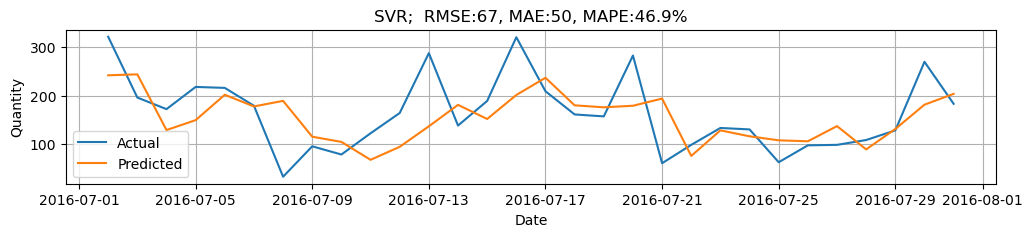

In [11]:
test.plot('SVR')

It seems that the predictions can follow the trend roughly.

## EOF